## Model Libraries / Data / Setup

    1. Package Imports

In [1]:
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import plotly.graph_objects as go

from scipy.spatial.distance import squareform, pdist
from pyproj import Proj, transform
from shapely.geometry import Point
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None  # default='warn'

    2. Function Definition

In [2]:
def dist_calc(lat1,lat2,lon1,lon2):
    d = math.dist([lat1,lon1],[lat2,lon2])
    return d

######
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point
######

def calculate_need(x,y):
    
    test_gdf = geopandas.GeoDataFrame()
    test_gdf['geometry'] = geopandas.points_from_xy([x],[y],crs="EPSG:26915")
    test_gdf['site_id'] = 'test_site'
    test_gdf['color'] = 2
    test_gdf = test_gdf.set_crs(26915)
    test_gdf['site_lat'] = test_gdf.geometry.centroid.y/1000
    test_gdf['site_lon'] = test_gdf.geometry.centroid.x/1000
    
    test_counties = counties[['COUNTY','county_lat','county_lon','POP2010']]
    test_counties['distance'] = np.sqrt((test_counties.county_lon-x/1000)**2 + (test_counties.county_lat-y/1000)**2)
    test_counties['dist_wt'] = 1 / test_counties.distance**1.5
    test_counties['pop_wt'] = test_counties.dist_wt * test_counties.POP2010

    test_pop = test_counties.pop_wt.sum() / test_counties.dist_wt.sum()
    exp_closest = -0.00009192*test_pop+18.30715947
    exp_within_25 = 0.00009816*test_pop-0.99121985
    
    test_sites = sites[['site_id','site_lat','site_lon']]
    test_sites['distance'] = np.sqrt((test_sites.site_lon-x/1000)**2 + (test_sites.site_lat-y/1000)**2)

    within_25 = len(test_sites[test_sites.distance<25])
    closest = test_sites.distance.min()
    
    z_closest = ((closest-exp_closest) - test_df.closest_diff.mean())/test_df.closest_diff.std()
    z_within_25 = ((exp_within_25-within_25) - test_df.within_25_diff.mean())/test_df.within_25_diff.std()
    z_agg = (z_closest+z_within_25)/2
    closest_score = 50-10*z_closest
    within_25_score = 50-10*z_within_25
    need_score = 50-10*z_agg
    
    d1 = {'Site': 'test_site', 'Coordinates [x,y]' : [[x,y]],'Population (est)': [test_pop]}
    d2 = {'Class': ['Actual','Expected','Score (20-80)'], 'Distance (mi) to closest site' : [closest,exp_closest,closest_score], 'Sites within 25 miles' : [within_25,exp_within_25,within_25_score]}
    d3 = {'Score (20-80)': [need_score]}
    
    table1 = pd.DataFrame(data=d1).set_index('Site')
    table2 = pd.DataFrame(data=d2).set_index('Class')
    table3 = pd.DataFrame(data=d3).set_index('Score (20-80)')
    
    display(table1,table2,table3)
    
def plot_coordinate(x,y):
    sites2 = sites[['geometry','site_id']]
    sites2['color'] = 'k'

    site_add = geopandas.GeoDataFrame()
    site_add['geometry'] = geopandas.points_from_xy([x],[y],crs="EPSG:26915")
    site_add['site_id'] = 'test_site'
    site_add['color'] = 'w'
    site_add = site_add.set_crs(26915)
    combine = geopandas.overlay(sites2.append(site_add),counties)

    plot = combine
    #df = geopandas.overlay(plot,counties)
    cmap = mpl.cm.Blues(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

    fig_size = [7.5,7.5]
    plt.rcParams["figure.figsize"] = fig_size

    fig, ax = plt.subplots()
    ax.set_title('Arkansas NAD83 Projection (UTM Zone 15N)')
    counties.plot(ax=ax,column='POP2010', cmap=cmap, legend=True, legend_kwds={'label': "Population by County",'orientation': "horizontal"})
    plot.plot(ax=ax,color=plot.color)
    plt.grid(color='w', linestyle = '--')
    plt.show()
    
def state_plot():

    plot = sites
    df = geopandas.overlay(plot,counties)
    cmap = mpl.cm.Blues(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

    fig_size = [7.5,7.5]
    plt.rcParams["figure.figsize"] = fig_size

    fig, ax = plt.subplots()
    counties.plot(ax=ax,column='POP2010', cmap=cmap, legend=True, legend_kwds={'label': "Population",'orientation': "horizontal"})
    plot.plot(ax=ax,color='k')
    plt.grid(color='w', linestyle = '--')
    plt.show()
    
def heat_plot():

    fig_size = [7.5,7.5]
    plt.rcParams["figure.figsize"] = fig_size
    
    fig, ax = plt.subplots()
    ax.set_title('Counties Needing Sites')
    heat_df.plot(ax=ax,column='Needed_Sites', cmap='coolwarm', legend=True, legend_kwds={'label': "Needed Sites",'orientation': "horizontal"})
    sites.plot(ax=ax,color='k')
    plt.grid(color='w', linestyle = '--')
    plt.show()
    
def show_x_highest_need_locations(x):
    return_df = pd.merge(rp,test_df[['test_site','pop_wt','closest','exp_closest','within_25','exp_within_25','Score']],left_on='test_id',right_on='test_site')
    return return_df.sort_values('Score')[['test_site','geometry','pop_wt','closest','exp_closest','within_25','exp_within_25','Score']].rename(columns={"geometry":"Coordinates (x,y)"}).head(x)

def grab_coordinates(x,y,zip_code,method):
    if method == 'zip':
        x = zip_df[zip_df.ZCTA == str(zip_code)]['x'].values[0]
        y = zip_df[zip_df.ZCTA == str(zip_code)]['y'].values[0]
    elif method == 'coo':
        x = x
        y = y
    else:
        x = None
        y = None
    return x,y

    3. Import Files

In [3]:
sites = geopandas.read_file(r"C:\Users\nastaja\Downloads\EMERG_MEDICAL_SERVICES_ADH\EMERG_MEDICAL_SERVICES_ADH.shp")
sites = sites[sites.state=='AR']
sites['site_lat'] = sites.geometry.centroid.y/1000
sites['site_lon'] = sites.geometry.centroid.x/1000
sites['site_id'] = sites.index + 1

counties = geopandas.read_file(r"C:\Users\nastaja\Downloads\\COUNTY_BOUNDARY\\COUNTY_BOUNDARY.shp")
counties['county_lat'] = counties.geometry.centroid.y/1000
counties['county_lon'] = counties.geometry.centroid.x/1000

zips = geopandas.read_file(r"C:\Users\nastaja\Downloads\\\ZIPCODE_TABULATION_CENSUS_2005_V1\\ZIPCODE_TAB_CENSUS_2005_V1.shp")
zip_df = zips[['ZCTA','geometry']].drop_duplicates(subset = 'ZCTA')
zip_df['x'] = zip_df.geometry.centroid.x
zip_df['y'] = zip_df.geometry.centroid.y

state = counties.geometry.unary_union
state = geopandas.GeoDataFrame(geometry=[state], crs=counties.crs)

### RANDOM POINT FILE IMPORT
rp = geopandas.read_file("rp.shp")

## Read distance matrix from .csv's
test_to_county = pd.read_csv('test_to_county.csv')
test_to_site = pd.read_csv('test_to_site.csv')

## Feature Engineering / Data Manipulation

    1. Generate (x) random points to enable analysis

In [4]:
### FOR MANUAL CALCULATION ONLY

'''
geodata = state

num_points = 150

# generate (x) points within the first county polygon in geodata
points = random_points_in_polygon(num_points, geodata.iloc[0].geometry)

rp = geopandas.GeoDataFrame(geometry=points).set_crs(26915)
rp['test_id'] = rp.index + 1
rp['test_lat'] = rp.geometry.centroid.y/1000
rp['test_lon'] = rp.geometry.centroid.x/1000
'''

"\ngeodata = state\n\nnum_points = 150\n\n# generate (x) points within the first county polygon in geodata\npoints = random_points_in_polygon(num_points, geodata.iloc[0].geometry)\n\nrp = geopandas.GeoDataFrame(geometry=points).set_crs(26915)\nrp['test_id'] = rp.index + 1\nrp['test_lat'] = rp.geometry.centroid.y/1000\nrp['test_lon'] = rp.geometry.centroid.x/1000\n"

    2. Simulate point-to-point distances to estimate population, metrics at individual sites

In [5]:
### FOR MANUAL SIMULATION ONLY: OTHERWISE READ FILE IN NEXT CELL

'''
test_county_matrix = []
for i in rp['test_id'].unique():
    for j in counties['COUNTY'].unique():
        lat1 = rp[rp['test_id']==i]['test_lat'].values[0]
        lat2 = counties[counties['COUNTY']==j]['county_lat'].values[0]
        lon1 = rp[rp['test_id']==i]['test_lon'].values[0]
        lon2 = counties[counties['COUNTY']==j]['county_lon'].values[0]
        distance = dist_calc(lat1,lat2,lon1,lon2)
        test_county_matrix.append([i,j,distance])
test_to_county = pd.DataFrame(test_county_matrix,columns=['test_site','COUNTY','Distance']).drop_duplicates(subset=['test_site','COUNTY'])
test_to_county.to_csv("test_to_county.csv")

test_site_matrix = []
for i in rp['test_id'].unique():
    for j in sites['site_id'].unique():
        lat1 = rp[rp['test_id']==i]['test_lat'].values[0]
        lat2 = sites[sites['site_id']==j]['site_lat'].values[0]
        lon1 = rp[rp['test_id']==i]['test_lon'].values[0]
        lon2 = sites[sites['site_id']==j]['site_lon'].values[0]
        distance = dist_calc(lat1,lat2,lon1,lon2)
        test_site_matrix.append([i,j,distance])
test_to_site = pd.DataFrame(test_site_matrix,columns=['test_site','site_id','Distance']).drop_duplicates(subset=['test_site','site_id'])
test_to_site.to_csv("test_to_site.csv")
'''

'\ntest_county_matrix = []\nfor i in rp[\'test_id\'].unique():\n    for j in counties[\'COUNTY\'].unique():\n        lat1 = rp[rp[\'test_id\']==i][\'test_lat\'].values[0]\n        lat2 = counties[counties[\'COUNTY\']==j][\'county_lat\'].values[0]\n        lon1 = rp[rp[\'test_id\']==i][\'test_lon\'].values[0]\n        lon2 = counties[counties[\'COUNTY\']==j][\'county_lon\'].values[0]\n        distance = dist_calc(lat1,lat2,lon1,lon2)\n        test_county_matrix.append([i,j,distance])\ntest_to_county = pd.DataFrame(test_county_matrix,columns=[\'test_site\',\'COUNTY\',\'Distance\']).drop_duplicates(subset=[\'test_site\',\'COUNTY\'])\ntest_to_county.to_csv("test_to_county.csv")\n\ntest_site_matrix = []\nfor i in rp[\'test_id\'].unique():\n    for j in sites[\'site_id\'].unique():\n        lat1 = rp[rp[\'test_id\']==i][\'test_lat\'].values[0]\n        lat2 = sites[sites[\'site_id\']==j][\'site_lat\'].values[0]\n        lon1 = rp[rp[\'test_id\']==i][\'test_lon\'].values[0]\n        lon2 = si

## Model Training

    1. Estimate Population based on proximity to other counties (Weighted Average)
    2. Estimate distance to closest site based on population density (Linear Regression)
    3. Estimate number of sites within 25 miles based on population density (Linear Regression)
    4. Generate "Score" on a (20-80) scale, where 20 is most in need of a new site (Weighted Z-Score Aggregation)

In [6]:
## Weighted population average based on distance
test_to_county['dist_wt'] = 1 / test_to_county.Distance**1.5
test_to_county = pd.merge(test_to_county,counties[['COUNTY','POP2010']],on='COUNTY')
test_to_county['pop_wt'] = test_to_county.dist_wt * test_to_county.POP2010
test_pop = pd.DataFrame(test_to_county.groupby('test_site')['pop_wt'].sum()/test_to_county.groupby('test_site')['dist_wt'].sum()).reset_index().rename(columns={0:"pop_wt"})

## Add count of sites within 25 miles of each point
counts_df = test_to_site[test_to_site.Distance<25].groupby('test_site').count().reset_index().rename(columns={"Distance":"count"})
test_to_site['within_25'] = test_to_site.merge(counts_df,on='test_site',how='left')['count'].fillna(0)

## Add distance of closest site
closest_df = test_to_site.groupby('test_site')['Distance'].min().reset_index().rename(columns={"Distance":"closest_dist"})
test_to_site['closest'] = test_to_site.merge(closest_df,on='test_site',how='left')['closest_dist']
test_df = pd.merge(test_to_site.drop_duplicates(subset='test_site')[['test_site','within_25','closest']],test_pop,on='test_site')

## Calculate expected closest distance, number of sites within 25 miles
test_df['exp_closest'] = -0.00009192*test_df.pop_wt+18.30715947
test_df['exp_within_25'] = 0.00009816*test_df.pop_wt-0.99121985

## Compute a score to demonstrate how well a location is covered for this type of building
test_df['closest_diff'] = test_df.closest - test_df.exp_closest
test_df['within_25_diff'] = test_df.exp_within_25 - test_df.within_25
test_df['z_closest'] = (test_df.closest_diff - test_df.closest_diff.mean())/test_df.closest_diff.std()
test_df['z_within'] = (test_df.within_25_diff - test_df.within_25_diff.mean())/test_df.within_25_diff.std()
test_df['z_agg'] = (test_df.z_closest + test_df.z_within)/2
test_df['Score'] = 50-10*test_df.z_agg

    5. Create Heat Map DataFrame

In [7]:
heat_df = geopandas.overlay(sites,counties)
heat_df = pd.merge(counties,sites.groupby('county')['site_id'].count().reset_index().rename(columns={"site_id":"site_count"}),how='left',left_on='COUNTY',right_on='county')
heat_df.site_count = heat_df.site_count.fillna(0)
heat_df['exp_sites'] = 0.00003759*heat_df.POP2010 + 0.87172343
heat_df['Needed_Sites'] = heat_df.exp_sites - heat_df.site_count

## State Plots

    1. PLOT: Entire State
    2. PLOT: Heat Map (Sites needed per county)

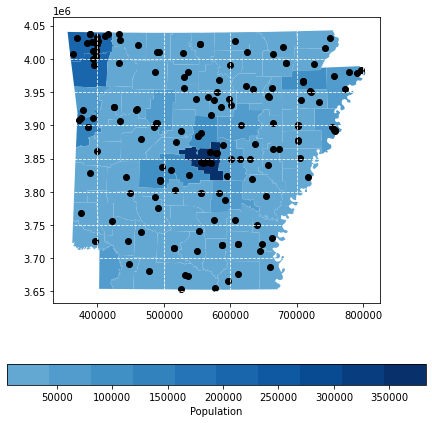

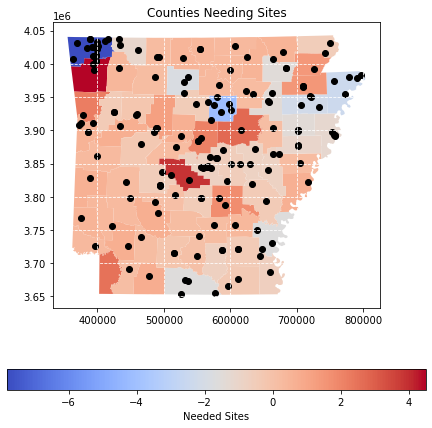

In [8]:
state_plot()
heat_plot()

## Enter Hypothetical Building Location for Location Score

       MULTIPLE (TABLE/PLOT): Show need-based metrics and Score for a HYPOTHETICAL BUILDING LOCATION:
        - Adjust (x,y) if using coordinates (NAD83 / UTM Zone 15N)
        - Adjust (zip_code) if using zip
        - Set (method) to 'coo' for (x,y) or 'zip' for zip codes
        
       TABLE:
        - Shows distance to closest site vs. expected
        - Shows number of sites within 25 miles vs. expected
        - Shows overall Score (lower needs a building more)
        
       PLOT:
        - Shows plot of all building type in the state (in black)
        - Shows hypothetical location of new building (in white)

,"Coordinates [x,y]",Population (est)
Site,,
test_site,"[601168.1274699278, 3782296.929099404]",49844.914869


,Distance (mi) to closest site,Sites within 25 miles
Class,,
Actual,11.091275,2.000000
Expected,13.725415,3.901557
Score (20-80),53.615240,39.711348


""
Score (20-80)
46.663294


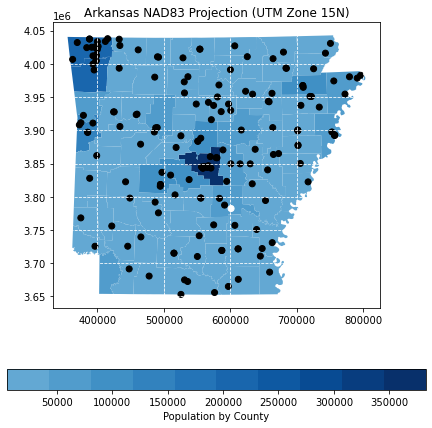

In [9]:
# Enter x,y coordinates OR zip code here
x = 525000
y = 3850000
zip_code = 71601
method = 'zip' ## Use 'coo' or 'zip'

x,y = grab_coordinates(x,y,zip_code,method)

calculate_need(x,y)
plot_coordinate(x,y)

## Show list of simulated sites with highest need of building type

In [10]:
show_x_highest_need_locations(10)

,test_site,"Coordinates (x,y)",pop_wt,closest,exp_closest,within_25,exp_within_25,Score
67,68,POINT (368845.098 3950277.504),64321.229578,29.552927,12.394752,0.0,5.322552,23.826540
13,14,POINT (511587.548 3747574.284),30124.740959,32.622252,15.538093,0.0,1.965825,32.958098
11,12,POINT (415922.777 3837708.716),33046.189325,29.271610,15.269554,0.0,2.252594,34.297356
5,6,POINT (710458.432 4018941.413),33722.305154,28.761107,15.207405,0.0,2.318962,34.425491
93,94,POINT (546816.585 3771044.802),33430.707750,28.419183,15.234209,0.0,2.290338,34.755957
1,2,POINT (516096.811 3762598.581),30754.348439,27.638948,15.480220,0.0,2.027627,36.170898
91,92,POINT (580131.459 3888069.967),63711.353044,19.668784,12.450812,2.0,5.262687,36.220268
0,1,POINT (549027.070 3912752.072),47114.033015,22.653971,13.976438,1.0,3.633494,36.920790
3,4,POINT (488510.998 3723332.271),26628.197177,27.921812,15.859496,0.0,1.622604,37.332745
52,53,POINT (621930.826 3797904.304),41848.515600,24.228569,14.460444,1.0,3.116630,37.570632


## Analysis / Model Steps

#### 1. Population vs. Distance to Closest Site

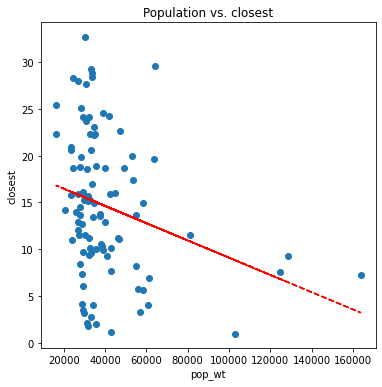

In [11]:
fig_size = [6,6]
plt.rcParams["figure.figsize"] = fig_size

x, y = test_df.pop_wt, test_df.closest
z = np.polyfit(x,y,1)
p = np.poly1d(z)

plt.scatter(x,y)
plt.plot(x,p(x),"r--")
plt.title("Population vs. "+y.name)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()

#### 2. Population vs. Number of sites within 25 miles

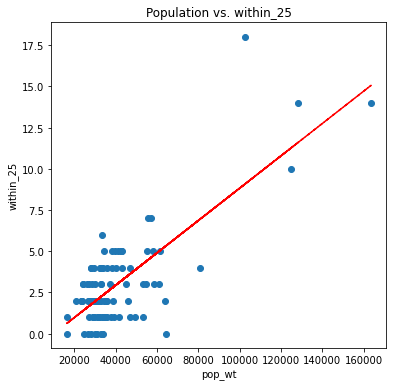

In [12]:
fig_size = [6,6]
plt.rcParams["figure.figsize"] = fig_size

x, y = test_df.pop_wt, test_df.within_25
z = np.polyfit(x,y,1)
p = np.poly1d(z)

plt.scatter(x,y)
plt.plot(x,p(x),"r--")
plt.title("Population vs. "+y.name)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()

#### 3. By County: Population by Number of Sites

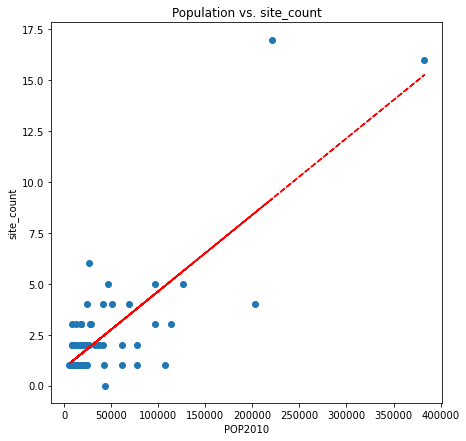

In [13]:
fig_size = [7,7]
plt.rcParams["figure.figsize"] = fig_size

x, y = heat_df.POP2010, heat_df.site_count
z = np.polyfit(x,y,1)
p = np.poly1d(z)

plt.scatter(x,y)
plt.plot(x,p(x),"r--")
plt.title("Population vs. "+y.name)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.show()